In [8]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.ioff()
import seaborn as sns
sns.set_style("whitegrid")
from scipy import stats, integrate
from scipy.stats import kendalltau

import warnings
warnings.filterwarnings('ignore')

# %matplotlib notebook

plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['grid.linestyle'] = '-'
plt.rcParams['font.size'] = 4.0

In [9]:
def label_rotation(ax, angle):
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    return ax

In [10]:
df = pd.read_pickle('../data/atti-dirigenti.pkl')
df.shape

(153206, 13)

In [11]:
df.head(5)

,CODICE_PRATICA,DATA_ATTO,DESCRIZIONE_TIPO_PRATICA,ID_TIPO,ID_TIPO_PRATICA,LINK_CONTENUTO_BINARIO,OGGETTO,PERSONA,STATUS,UFFICIO_AC,UFFICIO_DG,UFFICIO_SE,DETAIL_URL
0,20160140002016AD00000017201,2016-12-19,Atto dei dirigenti,ADN,MON,http://www.regione.toscana.it/bancadati/atti/C...,DGR 968/07 e s.m.i. Accreditamento degli organ...,013910,2,00000,50125,05873,http://www.regione.toscana.it/bancadati/atti/D...
1,20160140012016AD00000017466,2016-12-21,Atto dei dirigenti,ADN,MON,http://www.regione.toscana.it/bancadati/atti/C...,REG. CEE 2080/92 - AIUTI ALLE MISURE FORESTALI...,005595,2,00000,50117,05015,http://www.regione.toscana.it/bancadati/atti/D...
2,20160140022016AD00000017198,2016-12-19,Atto dei dirigenti,ADN,MON,http://www.regione.toscana.it/bancadati/atti/C...,"Servizi autorizzati ex art.14 L.R. 42/98 ""Norm...",019075,2,00000,50121,04838,http://www.regione.toscana.it/bancadati/atti/D...
3,20160140032016AD00000017208,2016-12-19,Atto dei dirigenti,ADN,MON,http://www.regione.toscana.it/bancadati/atti/C...,"L.R. 1/2006, DCR 3/2012, L.R. 1/2015 art.29, c...",020415,2,00000,50117,05018,http://www.regione.toscana.it/bancadati/atti/D...
4,20160140042016AD00000017268,2016-12-20,Atto dei dirigenti,ADN,MON,http://www.regione.toscana.it/bancadati/atti/C...,L.R. n. 87/1997 - Pubblicazione sul BURT dell'...,010826,2,00000,50116,05895,http://www.regione.toscana.it/bancadati/atti/D...


Let us deescribe the features

In [12]:
df.describe(include='all')

,CODICE_PRATICA,DATA_ATTO,DESCRIZIONE_TIPO_PRATICA,ID_TIPO,ID_TIPO_PRATICA,LINK_CONTENUTO_BINARIO,OGGETTO,PERSONA,STATUS,UFFICIO_AC,UFFICIO_DG,UFFICIO_SE,DETAIL_URL
count,153206,153206,153206,153206,153206,153206,153206,153206,153206.000000,153206,153206,153206,153206
unique,152455,4556,1,4,1,130730,148031,388,NaN,353,43,855,152455
top,20160116002016AD00000014089,2016-07-19 00:00:00,Atto dei dirigenti,AD,MON,http://www.regione.toscana.it/bancadati/atti/C...,"L.r. 55/2006 - ""Interventi in favore delle vit...",005549,NaN,00000,50073,0,http://www.regione.toscana.it/bancadati/atti/D...
freq,2,258,153206,62925,153206,21826,417,8022,NaN,44878,13890,29191,2
first,NaN,2000-01-04 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2018-03-09 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000509,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.140910,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,NaN


From the outcome of the describe we can notice that:
1. there are some duplicates by `CODICE_PRATICA`
2. the person 005549 occurs 8022 time as signer for acts while the most frequent office is 50073

As tasks:
- we are going to remove duplicates for `CODICE_PRATICA`

#### Drop duplicates by `CODICE_PRATICA`

In [13]:
df_drop = df.drop_duplicates(subset=['CODICE_PRATICA'])
df = df_drop

### Replace office id with names

Let us merge the index with the name of the offices.

In [14]:
df_office = pd.read_json('../data/strutture_processed.json')
df_office['ID'] = df_office['ID'].astype(str)

In [15]:
id_office_map = df_office.set_index(df_office['ID']).drop(['ID'], axis=1).to_dict()['NOME']

We check what are the offices that do not have a match

In [16]:
not_matched = []
matched = []
matched_id_name = {}

for i in df['UFFICIO_DG'].unique():
    if i in id_office_map:
        matched.append(id_office_map[i])
        matched_id_name[i] = id_office_map[i]
    else:
        not_matched.append(i)        

From the name of the offices it is interesting to see that there are:
- offices that changed the name 
- there are some abbreviations

we will create a replacement map to deal with these problems

In [17]:
matched_id_name

{'50125': 'DIREZIONE ISTRUZIONE E FORMAZIONE',
 '50117': 'DIREZIONE AGRICOLTURA E SVILUPPO RURALE',
 '50121': "DIREZIONE POLITICHE MOBILITA', INFRASTRUTTURE E TRASPORTO PUBBLICO LOCALE",
 '50116': 'DIREZIONE DIRITTI DI CITTADINANZA E COESIONE SOCIALE',
 '50123': "DIREZIONE ATTIVITA' PRODUTTIVE",
 '50118': 'DIREZIONE AMBIENTE ED ENERGIA',
 '50112': 'DIREZIONE GENERALE DIREZIONE GENERALE DELLA GIUNTA REGIONALE',
 '50119': 'DIREZIONE DIFESA DEL SUOLO E PROTEZIONE CIVILE',
 '50124': 'DIREZIONE CULTURA E RICERCA',
 '50115': 'DIREZIONE ORGANIZZAZIONE E SISTEMI INFORMATIVI',
 '50044': 'SEGRETERIE ORGANI POLITICI UFFICIO DI GABINETTO',
 '50007': 'D.G.  AVVOCATURA                                      ',
 '50127': 'DIREZIONE LAVORO',
 '50114': 'DIREZIONE PROGRAMMAZIONE E BILANCIO',
 '50122': 'DIREZIONE URBANISTICA, CASA E POLITICHE ABITATIVE',
 '50113': 'DIREZIONE AFFARI LEGISLATIVI, GIURIDICI ED ISTITUZIONALI',
 '50001': 'DIREZIONE GENERALE ORGANIZZAZIONE E SISTEMA INFORMATIV',
 '50004': 'DIREZ

In [18]:
to_replace = {
    '50001': '50115',
    '50069': '50115',
    '50102': '50115',
    '50083': '50004',
    '50079': '50116',
    '50118': '50202',
    '50121': '50201'
}

- We can replace the offices with wrong names
- we reaplace the codes with the canonical names of the offices

In [19]:
df_replaced = df
df_replaced['UFFICIO_DG'] = df['UFFICIO_DG'].replace(to_replace)

In [20]:
df= df_replaced.replace(matched_id_name)

In [21]:
df.head()

,CODICE_PRATICA,DATA_ATTO,DESCRIZIONE_TIPO_PRATICA,ID_TIPO,ID_TIPO_PRATICA,LINK_CONTENUTO_BINARIO,OGGETTO,PERSONA,STATUS,UFFICIO_AC,UFFICIO_DG,UFFICIO_SE,DETAIL_URL
0,20160140002016AD00000017201,2016-12-19,Atto dei dirigenti,ADN,MON,http://www.regione.toscana.it/bancadati/atti/C...,DGR 968/07 e s.m.i. Accreditamento degli organ...,013910,2,00000,DIREZIONE ISTRUZIONE E FORMAZIONE,05873,http://www.regione.toscana.it/bancadati/atti/D...
1,20160140012016AD00000017466,2016-12-21,Atto dei dirigenti,ADN,MON,http://www.regione.toscana.it/bancadati/atti/C...,REG. CEE 2080/92 - AIUTI ALLE MISURE FORESTALI...,005595,2,00000,DIREZIONE AGRICOLTURA E SVILUPPO RURALE,05015,http://www.regione.toscana.it/bancadati/atti/D...
2,20160140022016AD00000017198,2016-12-19,Atto dei dirigenti,ADN,MON,http://www.regione.toscana.it/bancadati/atti/C...,"Servizi autorizzati ex art.14 L.R. 42/98 ""Norm...",019075,2,00000,"DIREZIONE GENERALE POLITICHE MOBILITA', INFRAS...",04838,http://www.regione.toscana.it/bancadati/atti/D...
3,20160140032016AD00000017208,2016-12-19,Atto dei dirigenti,ADN,MON,http://www.regione.toscana.it/bancadati/atti/C...,"L.R. 1/2006, DCR 3/2012, L.R. 1/2015 art.29, c...",020415,2,00000,DIREZIONE AGRICOLTURA E SVILUPPO RURALE,05018,http://www.regione.toscana.it/bancadati/atti/D...
4,20160140042016AD00000017268,2016-12-20,Atto dei dirigenti,ADN,MON,http://www.regione.toscana.it/bancadati/atti/C...,L.R. n. 87/1997 - Pubblicazione sul BURT dell'...,010826,2,00000,DIREZIONE DIRITTI DI CITTADINANZA E COESIONE S...,05895,http://www.regione.toscana.it/bancadati/atti/D...


In [22]:
df.to_pickle('../data/atti-dirigenti-named.pkl')

## Data Exploration

As first step we want visualize the distrubition of the acts per:
- year
- employee
- office
    
### Acts Per Year

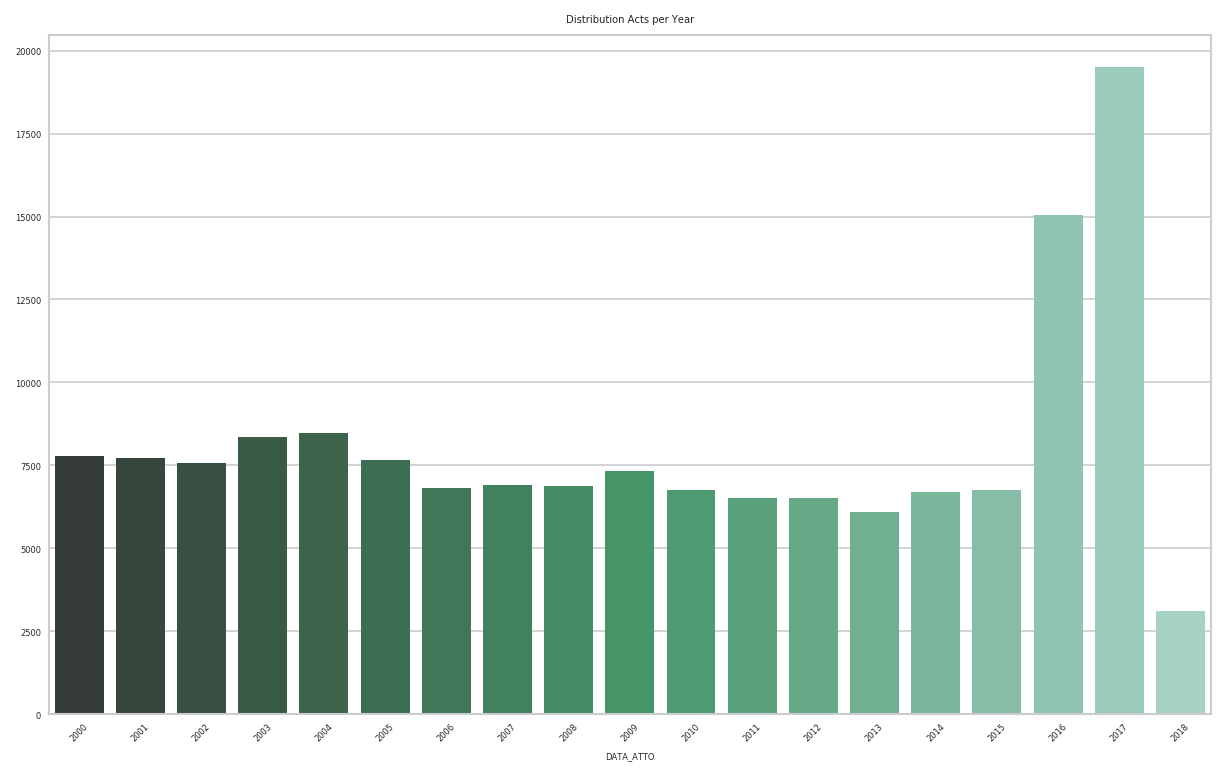

In [24]:
acts_per_year = df.groupby([df['DATA_ATTO'].dt.year])['CODICE_PRATICA'].count()

fig, ax = plt.subplots()
sns.barplot(acts_per_year.index, acts_per_year.values, palette="BuGn_d", ax=ax)
label_rotation(ax, 45)
fig.set_size_inches(10,6)
plt.title('Distribution Acts per Year')
plt.show(fig)

The distribution of the acts per year shows that there is an increase of acts for the years 2016 and 2017.
This is because in 2016 there was a grouping of the regional districts.

From another point of view is interesting to see the distribution of acts per person.

### Acts Per Employee

In [16]:
print('acts distribution per person')
acts_per_person = df.groupby([df['PERSONA']])['CODICE_PRATICA'].count().sort_values(ascending=False)
print(acts_per_person[:100])

acts distribution per person
PERSONA
005549    7989
020411    4316
005045    3816
015534    3778
007505    3060
014002    2645
013692    2103
005642    2013
005070    1943
017792    1836
013910    1735
007108    1619
014867    1584
007115    1579
014233    1557
015654    1532
005737    1495
002157    1458
020074    1413
001398    1408
016472    1377
005595    1334
005720    1312
014115    1234
012608    1232
008430    1219
014063    1208
015618    1202
002947    1190
016237    1140
          ... 
014944     687
005702     672
016001     670
018276     657
015208     650
001899     647
001352     636
015785     632
016325     628
005601     627
006184     626
014255     626
010692     609
009841     606
004977     604
013048     603
013448     592
016329     580
015063     563
015462     560
020367     559
019742     552
001149     530
002791     526
004248     525
013187     521
007097     519
015052     517
008572     517
001427     511
Name: CODICE_PRATICA, Length: 100, dtype: int64


We scale the values in the range [0:1] to make the visualization more clear and plot the distribution.

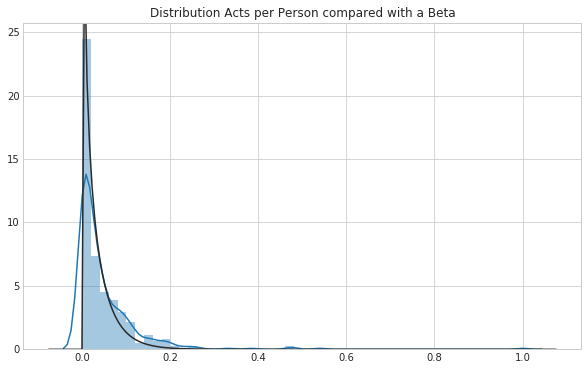

In [17]:
acts_per_person_scaled = (acts_per_person - acts_per_person.min()) / (acts_per_person.max() - acts_per_person.min())

fig, ax = plt.subplots()
sns.distplot(acts_per_person_scaled.values, kde=True, rug=False, ax=ax, fit=stats.beta)
fig.set_size_inches(10,6)
plt.title('Distribution Acts per Person compared with a Beta')
plt.show()

Here we can see that the distribution follows a beta distribution, which means that there is a 

### Distribution of Acts per Office

from here we can see what are the most active offices

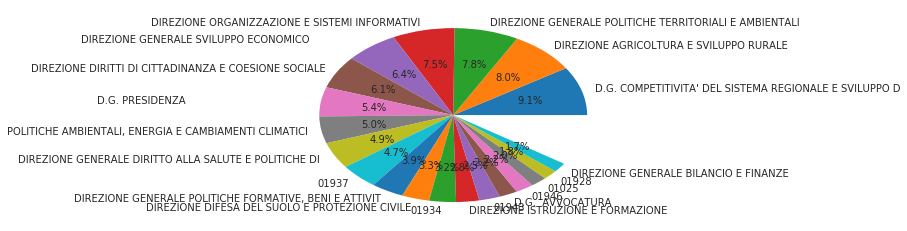

In [18]:
df_act_office = df.groupby(df['UFFICIO_DG'])['CODICE_PRATICA'].count()
df_act_office /= df_act_office.sum()
top = df_act_office.sort_values(ascending=False)[:20]
plt.pie(top, labels=top.index, autopct='%1.1f%%')
plt.show()

In [19]:
top

UFFICIO_DG
D.G. COMPETITIVITA' DEL SISTEMA REGIONALE E SVILUPPO D    0.090689
DIREZIONE AGRICOLTURA E SVILUPPO RURALE                   0.080207
DIREZIONE GENERALE POLITICHE TERRITORIALI E AMBIENTALI    0.077531
DIREZIONE ORGANIZZAZIONE E SISTEMI INFORMATIVI            0.075065
DIREZIONE GENERALE SVILUPPO ECONOMICO                     0.063783
DIREZIONE DIRITTI DI CITTADINANZA E COESIONE SOCIALE      0.060857
D.G. PRESIDENZA                                           0.054377
POLITICHE AMBIENTALI, ENERGIA E CAMBIAMENTI CLIMATICI     0.049936
DIREZIONE GENERALE DIRITTO ALLA SALUTE E POLITICHE DI     0.049057
01937                                                     0.046965
DIREZIONE GENERALE POLITICHE FORMATIVE, BENI E ATTIVIT    0.039494
DIREZIONE DIFESA DEL SUOLO E PROTEZIONE CIVILE            0.033184
01934                                                     0.032291
DIREZIONE ISTRUZIONE E FORMAZIONE                         0.027916
01943                                              

### Acts per Offices and per Year

Since the data range from 2001 to 2018 there are several office which are closed or merged with others.
Let see what are:
- the offices active in the last 2 years
- the offices not active

In [20]:
group_office_year = df.groupby(by=[df['UFFICIO_DG'], df['DATA_ATTO'].dt.year])['CODICE_PRATICA'].count()

If we unstack the grouped data we can see what are the years of activity of the offices.

In [21]:
df_office_year = group_office_year.unstack()
df_office_year

DATA_ATTO,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
UFFICIO_DG,,,,,,,,,,,,,,,,,,,
01025,NaN,1083.0,884.0,1063.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01027,NaN,472.0,505.0,467.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01923,241.0,264.0,320.0,260.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01928,711.0,666.0,697.0,636.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01931,1582.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01934,1346.0,1168.0,1126.0,1283.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01937,1638.0,1654.0,1723.0,2143.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01943,860.0,942.0,894.0,1137.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01946,638.0,849.0,918.0,941.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


By averaging per year we can see the average number of acts per year done by each office

In [22]:
df_office_year.mean(axis=1).sort_values(ascending=False)

UFFICIO_DG
DIREZIONE AGRICOLTURA E SVILUPPO RURALE                                               3057.000000
D.G. COMPETITIVITA' DEL SISTEMA REGIONALE E SVILUPPO D                                2304.333333
01931                                                                                 1582.000000
01937                                                                                 1432.000000
DIREZIONE GENERALE SVILUPPO ECONOMICO                                                 1389.142857
POLITICHE AMBIENTALI, ENERGIA E CAMBIAMENTI CLIMATICI                                 1268.833333
DIREZIONE DIFESA DEL SUOLO E PROTEZIONE CIVILE                                        1264.750000
01934                                                                                 1230.750000
DIREZIONE GENERALE POLITICHE TERRITORIALI E AMBIENTALI                                1182.000000
DIREZIONE GENERALE DIRITTO ALLA SALUTE E POLITICHE DI                                 1068.428571
DIREZIONE

As final exploration it would be interesting to see for the top person what is the distributions of acts per year

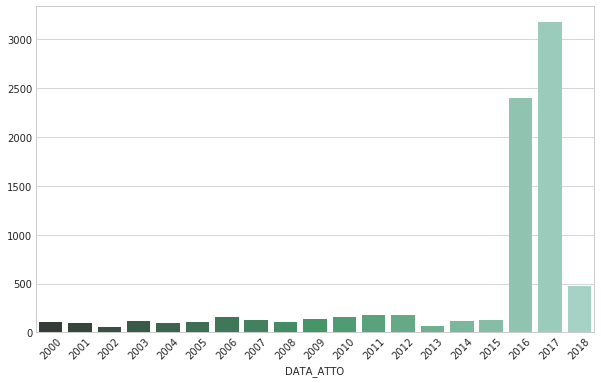

In [23]:
df_person = df[df['PERSONA'] == '005549']
acts_per_year_person = df_person.groupby([df_person['DATA_ATTO'].dt.year])['CODICE_PRATICA'].count()

fig, ax = plt.subplots()
sns.barplot(acts_per_year_person.index, acts_per_year_person.values, palette="BuGn_d", 
            ax=ax, order=acts_per_year_person.index)
label_rotation(ax, 45)
fig.set_size_inches(10,6)
plt.show(fig)

Moreover, we can see that he works for different offices

In [24]:
df_person = df[df['PERSONA'] == '005549']
df_person['UFFICIO_DG'].unique()

array(['DIREZIONE AGRICOLTURA E SVILUPPO RURALE',
       'DIREZIONE GENERALE SVILUPPO ECONOMICO                 ',
       "D.G. COMPETITIVITA' DEL SISTEMA REGIONALE E SVILUPPO D", '01934',
       'ALTRI UFFICI'], dtype=object)

Here we can see that apart 2016 and 2017 this person did in average the same number of acts.

It would be interesting to see the contribution of each person per office in order to spot:
- when a person moves from one office to another
- Who is in charge of an office (considering that if a person is in charge sign more acts than the others)

## Next Step

After the data exploration the next steps of this notebook is to write a classification model able to predict the office that writes the act given the text in the subject (Oggetto) attribute.

In [25]:
pd.to_pickle(df,'../data/atti-dirigenti-processed.pkl')